# Data Prep
--- 

In [96]:
import pandas as pd # managing data in data frame
import numpy as np # generating numbers for alpha values

import statsmodels.formula.api as smf # for linear modeling
import statsmodels.regression.linear_model as sma

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


feature_test = pd.read_csv('data/dengue_features_test.csv')
feature_train = pd.read_csv('data/dengue_features_train.csv')
labels_train = pd.read_csv('data/dengue_labels_train.csv')

* **feature_train**: is the climate data for a week of a given year
* **labels_train**: number of dengue cases for a week and year
* **feature_test**: Use to test our model


In [97]:
# merge the data sets into one fat table
new_df = pd.merge(feature_train, labels_train,  how='left', left_on=['city','year', 'weekofyear'], right_on = ['city','year', 'weekofyear'])

# Normalize data
new_df['reanalysis_air_temp_c'] = new_df['reanalysis_air_temp_k'] - 273.15
new_df['reanalysis_tdtr_c'] = new_df['reanalysis_tdtr_k'] - 273.15
new_df['reanalysis_avg_temp_c'] = new_df['reanalysis_avg_temp_k'] - 273.15
new_df['reanalysis_dew_point_temp_c'] = new_df['reanalysis_dew_point_temp_k'] - 273.15
new_df['reanalysis_min_air_temp_c'] = new_df['reanalysis_min_air_temp_k'] - 273.15
new_df['reanalysis_max_air_temp_c'] = new_df['reanalysis_max_air_temp_k'] - 273.15

normalized_df = new_df.drop(['reanalysis_air_temp_k', 'reanalysis_tdtr_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_max_air_temp_k'], axis=1)
normalized_df = normalized_df.drop(['city', 'week_start_date'], axis=1)
normalized_df = normalized_df.dropna()

In [98]:
# Adding one new column, average temperature
normalized_df['new_avg_temp_c'] = ( normalized_df.station_avg_temp_c + normalized_df.reanalysis_avg_temp_c)/ 2

In [4]:
# Split data
from sklearn.model_selection import train_test_split

# normalized_dropped = normalized_df.drop(['total_cases'], axis=1)
train_features, test_features, train_outcome, test_outcome = train_test_split(
                                                                               normalized_df,      # features
                                                                               normalized_df.total_cases,    # outcome
                                                                               test_size=0.20, # percentage of data to use as the test set
                                                                               random_state=15 # set a random state so it is consistent (not required!)
                                                                            )

print("train features shape", train_features.shape)
print("test features shape", test_features.shape)
print("full training datasets features shape", train_features.shape)
print("test outcomes shape", test_outcome.shape)
print("train outcomes shape", train_outcome.shape)

train features shape (959, 24)
test features shape (240, 24)
full training datasets features shape (959, 24)
test outcomes shape (240,)
train outcomes shape (959,)


In [5]:
X_test = test_features.drop(['total_cases'], axis=1)
Y_test = test_features.total_cases

X_train = train_features.drop(['total_cases'], axis=1)
Y_train = train_features.total_cases

<br>
<br>
<br>
<br>

# Feature Selection - Lasso
---

> What is it? "Feature selection… is the process of selecting a subset of relevant features for use in model construction".
>
> "Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.
> Fewer attributes is desirable because it reduces the complexity of the model, and a simpler model is simpler to understand and explain" ([sources](https://machinelearningmastery.com/an-introduction-to-feature-selection/)).



In [6]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=1e-4, normalize=True)
lassoReg.fit(train_features, train_outcome)
pred = lassoReg.predict(test_features)

In [7]:
# Code reference: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/#four

def getBestAlpha(dataFrame, outcomeFeatureName, alpha_values, train_features, train_outcome ,test_features):
    """
    
    Returns a pandas data frame row with best rss score and alpha.
    """
    
    column_names= ['alpha_lasso', 'rss'] + (list(dataFrame.drop([outcomeFeatureName], axis=1).columns))
    
    alpha_df = pd.DataFrame(columns=column_names)
    
    for alpha_val in alpha_values:
        lassoReg = Lasso(alpha=alpha_val, normalize=True)
        lassoReg.fit(train_features.drop(['total_cases'], axis=1), train_outcome)
        pred = lassoReg.predict(test_features.drop(['total_cases'], axis=1))

        rss = sum((pred-test_features.total_cases)**2)

        new_row = [alpha_val, rss] + (list(lassoReg.coef_))
        alpha_df.loc[len(alpha_df)] = new_row 


    return(alpha_df[alpha_df.rss == alpha_df.rss.min()])
    
    

In [8]:

print("\n\n--- Getting Best Alpha Value ---")
alpha_values = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2,1, 5, 10]
row = getBestAlpha(normalized_df, "total_cases", alpha_values, train_features, train_outcome ,test_features)
print("* First best alpha value from a broad array of numbers between 1e-15 and 10.0: " , (row.alpha_lasso).iloc[0])

alpha_values = np.arange(0.0001, 0.002, 0.0001)
row2 = getBestAlpha(normalized_df, "total_cases", alpha_values, train_features, train_outcome ,test_features)
print("* Narrowing down again, between 0.0001 and 0.002. Best alpha value is " , (row2.alpha_lasso).iloc[0])

alpha_values = np.arange(0.0004, 0.0006, 0.00001)
row3 = getBestAlpha(normalized_df, "total_cases", alpha_values, train_features, train_outcome ,test_features)
print("* Final narrow down between 0.0004 and 0.0006. Final best alpha value is " , (row3.alpha_lasso).iloc[0])

# R^2 = 0.2365, only explains 23.65% of the data with the current feature selections
# Goal: Increase the R^2 over time
lassoReg = Lasso(alpha=(row3.alpha_lasso).iloc[0], normalize=True)
lassoReg.fit(train_features.drop(['total_cases'], axis=1), train_outcome)
train_score = lassoReg.score(train_features.drop(['total_cases'], axis=1), train_outcome)
print("* Our current lasso regression model, using the best alpha value found describes " + str(round(train_score, 2)) + " of our data. \n  Let's see if our next models can do better!")

alpha = (row3.alpha_lasso).iloc[0]

row3




--- Getting Best Alpha Value ---
* First best alpha value from a broad array of numbers between 1e-15 and 10.0:  0.001
* Narrowing down again, between 0.0001 and 0.002. Best alpha value is  0.0005
* Final narrow down between 0.0004 and 0.0006. Final best alpha value is  0.0005400000000000003
* Our current lasso regression model, using the best alpha value found describes 0.24 of our data. 
  Let's see if our next models can do better!


,alpha_lasso,rss,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,...,station_max_temp_c,station_min_temp_c,station_precip_mm,reanalysis_air_temp_c,reanalysis_tdtr_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_min_air_temp_c,reanalysis_max_air_temp_c,new_avg_temp_c
14,0.00054,144878.645546,-1.425414,0.176532,-12.898148,8.967925,-6.463009,5.513956,0.0,0.006939,...,-1.200511,0.486708,-0.0,0.0,0.0,-11.542931,-9.978702,0.000827,1.33848,-0.0


In [9]:
# Show rows that do not have a 0 zero beta coefficient.

for col in row3:
    if abs(row3[col].iloc[0]) == 0.0:
        row3 = row3.drop(col, axis=1)
row3.shape

(1, 19)

We started with 23 features
Then minus `total cases` that's 22.

After doing lasso we now have 17 features available.

<br>
<br>
<br>
<br>

# Modeling
---

We have now:
* normalized the data
* split the data
* selected our best alpha value (feature selection) 

It is time to run several models against our data and observe the results.

### Predictions Data Frame

In [10]:
# Build Data Frame that will store all predictions results
results_df = pd.DataFrame()
results_df['total_cases'] = test_features.total_cases

### Multivariate linear regression with lasso 

```
27.95955519 : reanalysis_specific_humidity_g_per_kg
-11.542931 : reanalysis_avg_temp_c
-12.898148 : ndvi_ne
-9.978702 : reanalysis_dew_point_temp_c
8.967925 : ndvi_nw

-6.463: ndvi_se
5.51 :  ndvi_sw
-2.9: reanalysis_relative_humidity_percent

-1.659: station_avg_temp_c
-1.4254: year
1.338: reanalysis_max_air_temp_c
0.48670: station_min_temp_c
```

In [11]:
def buildMultiString(arr, dependantName):
    """
    Takes in an array of features and the name of your dependant
    variable and returns a properly formatted forumal for
    multivariate regression.
    """
    result = dependantName + " ~ " + arr[0]
    for feature in arr[1:]:
        result += " + " + feature
    return(result)
    

In [12]:
# Below are feature sets, each one in order based on our lasso work.
small_features = ["reanalysis_specific_humidity_g_per_kg",
 "reanalysis_avg_temp_c",
 "ndvi_ne",
 "reanalysis_dew_point_temp_c",
 "ndvi_nw"
]
medium_features  = small_features + ["ndvi_se", "ndvi_sw", "reanalysis_relative_humidity_percent" ]
big_features  = medium_features + ["station_avg_temp_c", "year"]
biggest_of_bois_features = big_features + ["reanalysis_max_air_temp_c", "station_min_temp_c"]

# Prepare formulas
formula_small = buildMultiString(small_features, "total_cases")
formula_med = buildMultiString(medium_features, "total_cases")
formula_big = buildMultiString(big_features, "total_cases")
formula_biggest = buildMultiString(biggest_of_bois_features, "total_cases")

In [13]:
# Multivarite regression
multModel = smf.ols(formula_biggest, data=train_features).fit()
multivariate_preds = multModel.predict(test_features)
results_df['multi_preds'] = multivariate_preds
multModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_cases   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     23.63
Date:                Mon, 04 Mar 2019   Prob (F-statistic):           1.94e-46
Time:                        23:03:52   Log-Likelihood:                -4536.0
No. Observations:                 959   AIC:                             9098.
Df Residuals:                     946   BIC:                             9161.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              3489.6498    440.258      7.926      0.000    2625.654    4353.646
reanalysis_specific_humidity_g_per_kg    36.4167      9.833      3.704      0.000      17.120      55.713
reanalysis_avg_temp_c                   -13.1680      4.116     -3.199      0.001     -21.246      -5.090
ndvi_ne                                 -14.0630     13.374     -1.051      0.293     -40.310      12.184
reanalysis_dew_point_temp_c             -15.8934     10.133     -1.568      0.117     -35.780       3.993
ndvi_nw                                   7.8654     15.143      0.519      0.604     -21.852      37.583
ndvi_se                                  -0.3394     21.567     -0.016      0.987     -42.663      41.985
ndvi_sw                                   3.5697     20.522      0.174      0.862     -36.704      43.844
reanalysis_relative_humidity_percent     -3.3896      0.726     -4.668      0.000      -4.815      -1.965
station_avg_temp_c                       -3.6432      1.536     -2.371      0.018      -6.658      -0.628
year                                     -1.5397      0.218     -7.052      0.000      -1.968      -1.111
reanalysis_max_air_temp_c                 1.7443      0.926      1.884      0.060      -0.073       3.561
station_min_temp_c                        1.0404      1.224      0.850      0.395      -1.361       3.442
==============================================================================
Omnibus:                      808.899   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23806.821
Skew:                           3.732   Prob(JB):                         0.00
Kurtosis:                      26.239   Cond. No.                     9.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Ridge Regression

In [14]:
# Ridge Regression

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=(row3.alpha_lasso).iloc[0],normalize=True)
ridge_reg = ridge_reg.fit(X_train, Y_train)

ridge_preds = ridge_reg.predict(X_test)
results_df['ridge_preds'] = ridge_preds

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Determine best number of neighbors
accuracies = []

for neighbor in range (1, 20):
    knn_clf = KNeighborsClassifier(n_neighbors=neighbor) 
    knn_clf.fit(X_train, Y_train)
    score = accuracy_score(knn_clf.predict(X_test), Y_test)
    accuracies.append(score)
    
most_accur = max(accuracies)
neighbor = accuracies.index(most_accur)
neighbor # We find that k = 12 produces the most accurate values of 12.08%

16

In [16]:
knn_clf = KNeighborsClassifier(n_neighbors=neighbor)
knn_model = knn_clf.fit(X_train, Y_train)
results_df["knn_preds"] = knn_model.predict(X_test)

### Lasso regression

In [17]:
lassoReg = Lasso(alpha=alpha, normalize=True)
lassoReg.fit(X_train, Y_train)
lasso_preds = lassoReg.predict(X_test)
results_df['lasso_preds'] = lasso_preds

### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=92)
tree_fit = tree_clf.fit(X_train, Y_train)
tree_preds = tree_fit.predict(X_test)
results_df['tree_preds'] = tree_preds

In [19]:
results_df.head()

,total_cases,multi_preds,ridge_preds,knn_preds,lasso_preds,tree_preds
121,59,44.082773,45.181947,2,45.158851,21
1202,5,0.339421,2.352861,0,2.179550,9
159,10,35.559827,32.777274,10,33.031947,16
1305,3,-12.434199,-9.118408,0,-8.451486,5
1231,26,11.274763,8.881232,1,8.810301,8


<br>
<br>
<br>
<br>

# Cross Validation
---

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

folds = KFold(n_splits=10, shuffle=True)

# cross_val_score = Array of scores of the estimator for each run of the cross validation.

def run_Cross_validation(model_object, model_name):
    scores = cross_val_score(model_object, X_train, Y_train, cv = folds)
    print(model_name, "MEAN:", round(scores.mean(), 2), "MIN:", round(scores.min(), 2), "MAX:", round(scores.max(), 2))

In [21]:
run_Cross_validation(knn_clf, "KNN")
run_Cross_validation(lassoReg, "Lasso")
run_Cross_validation(ridge_reg, "Ridge")
run_Cross_validation(tree_clf, "Tree")

KNN MEAN: 0.06 MIN: 0.01 MAX: 0.08
Lasso MEAN: 0.17 MIN: -0.15 MAX: 0.28
Ridge MEAN: 0.19 MIN: -0.04 MAX: 0.38
Tree MEAN: 0.08 MIN: 0.05 MAX: 0.09


### Grid Search

In [22]:
from sklearn.model_selection import GridSearchCV

# for knn
param_grid = {'n_neighbors':range(1, 20), 'weights':["uniform", "distance"]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, Y_train)
knn_params = grid_search.cv_results_['params'][grid_search.best_index_]
knn_score = grid_search.score(X_test, Y_test)
print("KNN params:", knn_params, "KNN score:", knn_score)

KNN params: {'n_neighbors': 4, 'weights': 'uniform'} KNN score: 0.0375


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
# for tree
from sklearn.tree import DecisionTreeClassifier

param_grid1 = {'random_state': np.arange(1, 100)}
tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid1, cv=10, return_train_score=True)
tree_grid.fit(X_train, Y_train)
tree_params = tree_grid.cv_results_['params'][tree_grid.best_index_]
tree_score = tree_grid.score(X_test, Y_test)
print("Tree params:", tree_params, "Tree score:", tree_score)

Tree params: {'random_state': 37} Tree score: 0.12083333333333333


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
# Guide: https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8

# Lasso GridCV
lasso = Lasso()
# parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2]}

parameters = {'alpha': np.arange(0.0008, 0.001, 0.00001)}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, Y_train)
print("Best params Lasso: {}, lasso score: {}".format(lasso_regressor.best_params_, round(lasso_regressor.best_score_, 2)))

Best params Lasso: {'alpha': 0.0009900000000000004}, lasso score: -777.35


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
# Ridge GridCV
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2,1, 5, 10]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, Y_train)
print("Best params Ridge: {}, Ridge score: {}".format(ridge_regressor.best_params_, round(ridge_regressor.best_score_, 2)))

Best params Ridge: {'alpha': 5}, Ridge score: -775.7


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
def calculate_RSS(actual, predicted, predicted_method):
    """
    Given the actual values of a dataset and the predicted values, this method calculates the RSS
    """
    if len(actual) == len(predicted):
        rss = 0
        for i in range (0, len(actual)):
            residual = actual[i] - predicted[i]
            rss = rss + sum(residual * residual)
        print(predicted_method, rss)
        return rss

In [27]:
# Create RSS dataframe
rss_df = pd.DataFrame()

for col in results_df.columns[1:]:
    rss_score = calculate_RSS(list([results_df.total_cases]), list([results_df[col]]), str(col))
    rss_df[str(col)] = [rss_score]

multi_preds 146602.61556906314
ridge_preds 145019.27920884843
knn_preds 234678
lasso_preds 144878.64554617408
tree_preds 202654


In [28]:
rss_df

,multi_preds,ridge_preds,knn_preds,lasso_preds,tree_preds
0,146602.615569,145019.279209,234678,144878.645546,202654


### Validation and Visualization

Choosing to visualize knn results and lasso results because those models have the lowest RSS scores.

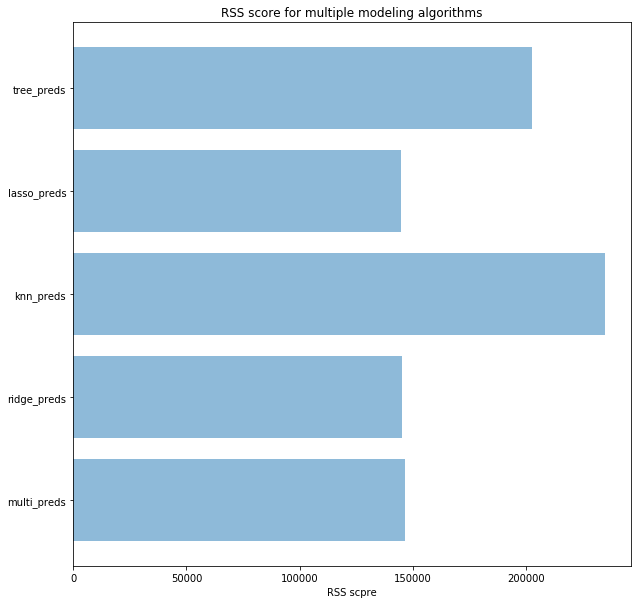

In [29]:
# Bar chart of RSS values
features = list(rss_df.columns.values)
corr_nums = list(rss_df.loc[0])

plt.figure(figsize=(10,10))
plt.barh(features, corr_nums, align='center', alpha=0.5)
plt.yticks(features, features)
plt.xlabel('RSS scpre')
plt.title('RSS score for multiple modeling algorithms')

plt.show()

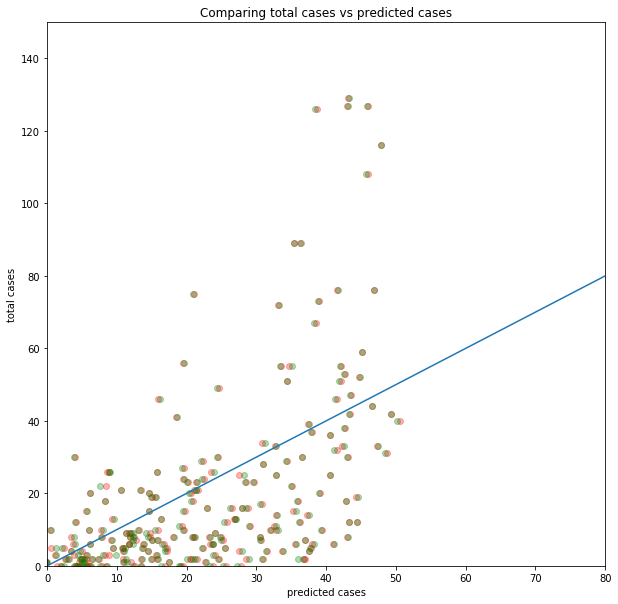

In [30]:
# The more linear the results are, the more accurately it predicts the total cases
plt.figure(figsize=(10,10))
plt.axis((0,80,0,150))
plt.scatter(results_df.ridge_preds, results_df.total_cases, alpha = 0.3, c="red")
plt.scatter(results_df.lasso_preds,results_df.total_cases, alpha = 0.3, c="green")
plt.title("Comparing total cases vs predicted cases")
plt.xlabel("predicted cases")
plt.ylabel("total cases")
plt.plot([0, 150], [0, 150])

plt.show()

#### Interpretation

A linear line where x = y means the predicted number of cases is 100% accurate

RSS values for lasso and ridge and quite similar, though we are surprised to see how much the predicted cases overlap

Let's zoom in to take a closer look.


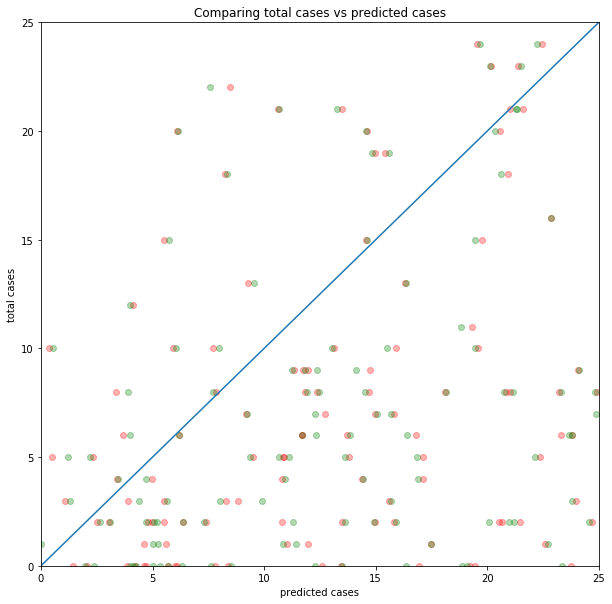

In [31]:
# Zooming in on the density of clusters
plt.figure(figsize=(10,10))
plt.axis((0,25,0,25))
plt.scatter(results_df.ridge_preds, results_df.total_cases, alpha = 0.3, c="red")
plt.scatter(results_df.lasso_preds,results_df.total_cases, alpha = 0.3, c="green")
plt.title("Comparing total cases vs predicted cases")
plt.xlabel("predicted cases")
plt.ylabel("total cases")
plt.plot([0, 25], [0, 25])

plt.show()

#### Interpretation

Most points in both the lasso regression and ridge regression are quite close to one another. Perhaps this is because both modeling methods are using learning-based feature selection and the same alpha value to determine the weight on each feature.

As our final visualization, we'll take the model with the lowest RSS value (Lasso regression) and input the best feature values we should use accourd to our GridSearch, where the alpha value = 0.0009900000000000004.

In [32]:
lassoReg_improved = Lasso(alpha=0.0009900000000000004, normalize=True)
lassoReg_improved.fit(X_train, Y_train)
lasso_preds_improved = lassoReg_improved.predict(X_test)

improved_df = pd.DataFrame()
improved_df['total_cases'] = test_features.total_cases
improved_df['lasso_preds_improved'] = lasso_preds_improved


In [34]:
calculate_RSS(list([improved_df.total_cases]), list([improved_df.lasso_preds_improved]), 'lasso_improved')
calculate_RSS(list([results_df.total_cases]), list([results_df.lasso_preds]), 'lasso_previous')


lasso_improved 144980.5080603656
lasso_previous 144878.64554617408


144878.64554617408

#### Lasso Improvements Interpretation

According to grid search which had a wider range of alpha values to choose from, determining the alpha values based on the 'neg_mean_squared_error' scoring allowed for a similar RSS value. 

We will visualize the predicted results with the improved lasso regression

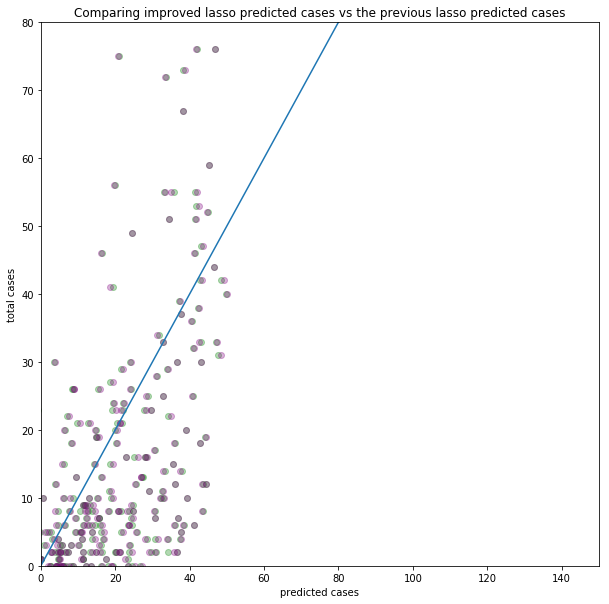

In [35]:
# Comparing lasso regression models with different alphas
plt.figure(figsize=(10,10))
plt.axis((0,150,0,80))
plt.scatter(improved_df.lasso_preds_improved, results_df.total_cases, alpha = 0.3, c="green")
plt.scatter(results_df.lasso_preds, results_df.total_cases, alpha = 0.3, c="purple")
plt.title("Comparing improved lasso predicted cases vs the previous lasso predicted cases")
plt.xlabel("predicted cases")
plt.ylabel("total cases")
plt.plot([0, 150], [0, 150])

plt.show()

<br>
<br>
<br>
<br>

## Competition Prediction

<br>

**Lasso Regression** on test data

In [99]:
feature_test = feature_test.dropna()
competition_df = feature_test[['city','year', 'weekofyear']]

They are fairly similar
Previous lasso regression with the lower RSS score would be more accurate = closer to the linear line of accuracy

In [102]:
# Build model on all of our data, not only split data

lassoReg_competition = Lasso(alpha=alpha, normalize=True)
lassoReg_competition.fit(normalized_df.drop(['total_cases'], axis =1), normalized_df.total_cases)


Lasso(alpha=0.0005400000000000003, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [103]:
# Normalize our test data to make it the same format at our feature data

feature_test['reanalysis_air_temp_c'] = feature_test['reanalysis_air_temp_k'] - 273.15
feature_test['reanalysis_tdtr_c'] = feature_test['reanalysis_tdtr_k'] - 273.15
feature_test['reanalysis_avg_temp_c'] = feature_test['reanalysis_avg_temp_k'] - 273.15
feature_test['reanalysis_dew_point_temp_c'] = feature_test['reanalysis_dew_point_temp_k'] - 273.15
feature_test['reanalysis_min_air_temp_c'] = feature_test['reanalysis_min_air_temp_k'] - 273.15
feature_test['reanalysis_max_air_temp_c'] = feature_test['reanalysis_max_air_temp_k'] - 273.15



feature_test = feature_test.drop(['reanalysis_air_temp_k', 'reanalysis_tdtr_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_max_air_temp_k'], axis=1)
feature_test = feature_test.drop(['city', 'week_start_date'], axis=1)

# Adding one new column, average temperature
feature_test['new_avg_temp_c'] = ( feature_test.station_avg_temp_c + feature_test.reanalysis_avg_temp_c)/ 2


In [104]:
lasso_preds_competition = lassoReg_competition.predict(feature_test)
competition_df['total_cases'] = lasso_preds_competition

In [107]:
competition_df.to_csv("data/SUBMISSION.csv", index=False)

<br>

**Ridge Regression** on test data

In [108]:
# start with fresh df
competition_df = competition_df.drop(['total_cases'], axis=1)

# run ridge
ridge_reg = Ridge(alpha=(row3.alpha_lasso).iloc[0],normalize=True)
ridge_reg = ridge_reg.fit(normalized_df.drop(['total_cases'], axis =1), normalized_df.total_cases)

ridge_preds = ridge_reg.predict(feature_test)
competition_df['total_cases'] = ridge_preds

In [109]:
competition_df.to_csv("data/SUBMISSION_2.csv", index=False)